In [2]:
import os
import pickle
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import geopandas as gpd

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.font_manager as font_manager
import matplotlib as mpl

from matplotlib import rcParams
from matplotlib.lines import Line2D
from matplotlib.colors import ListedColormap

import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

from scipy import stats
from shapely import wkt

warnings.filterwarnings('ignore')

pathdata = '/home/daniu/Documentos/fundar/indice-mercado-trabajo-ingresos/'
pathdata = '/Users/danielarisaro/Documents/Fundar/indice-mercado-trabajo-ingresos/'
pathdata = '/home/daniufundar/Documents/Fundar/indice-mercado-trabajo-ingresos/'

# Fuente para los graficos
font_dir = [pathdata + 'basemaps/Archivo/']
for font in font_manager.findSystemFonts(font_dir):
    font_manager.fontManager.addfont(font)

rcParams['font.family'] = 'Archivo'

# Colores fundar
fundar_colores_primarios = ['#7BB5C4', '#9FC1AD', '#D3D3E0',  '#8d9bff', '#FF9750', '#FFD900',]
fundar_colores_secundarios = ['#B5E0EA', '#B3B3B3', '#848279', '#AFA36E', '#5D896F', '#9C9CBC', '#E27124']
fundar_white = '#F5F5F5'
fundar_black = '#151515'

In [3]:
# Cargo geodataframe y reproyectamos con Mercator
df_total = pd.read_csv(pathdata + 'data_input/geodb.csv', index_col=[0])
df_total['geometry'] = df_total['geometry'].apply(wkt.loads)
gdf_total = gpd.GeoDataFrame(df_total, geometry='geometry', crs='epsg:4326')
gdf_total['centroid'] = gdf_total.centroid
gdf_reprojected = gdf_total.to_crs("EPSG:3395")

In [4]:
# Cargo indicadores y trunco en 100
ratio_actividad = pd.read_csv(pathdata + 'data_output/indicadores/01_ratio_actividad.csv', index_col=0)
empleo_asalariado_con_descuento = pd.read_csv(pathdata + 'data_output/indicadores/02_empleo_asalariado_con_descuento.csv', index_col=0)
horas_remuneradas_media = pd.read_csv(pathdata + 'data_output/indicadores/03_horas_promedio_ocup_ppal.csv', index_col=0)
ingreso_salarial_media = pd.read_csv(pathdata + 'data_output/indicadores/04_ingreso_salarial.csv', index_col=0)
ratio_minutos_promedio_no_pago = pd.read_csv(pathdata + 'data_output/indicadores/05_tiempo_no_remunerado.csv', index_col=0)
inactivos_con_ingreso = pd.read_csv(pathdata + 'data_output/indicadores/06_dependencia_economica.csv', index_col=0)
hogares_jefatura = pd.read_csv(pathdata + 'data_output/indicadores/07_hogares_no-pobres_jefatura.csv', index_col=0)

ratio_actividad = ratio_actividad.sort_index()
empleo_asalariado_con_descuento = empleo_asalariado_con_descuento.sort_index()
horas_remuneradas_media = horas_remuneradas_media.sort_index()
ingreso_salarial_media = ingreso_salarial_media.sort_index()
ratio_minutos_promedio_no_pago = ratio_minutos_promedio_no_pago.sort_index()
inactivos_con_ingreso = inactivos_con_ingreso.sort_index()
hogares_jefatura = hogares_jefatura.sort_index()

variables = [ratio_actividad, empleo_asalariado_con_descuento, horas_remuneradas_media, ingreso_salarial_media, ratio_minutos_promedio_no_pago, inactivos_con_ingreso, hogares_jefatura]
columnas = ['Actividad', 'Formalidad', 'Horas promedio remuneradas', 'Ingreso laboral promedio', 'Tiempo TNR', 'Dependencia', 'No Pobreza']

for columna, variable in zip(columnas,variables):
    variable[columna] = np.where(variable[columna] > 100, 100, variable[columna])

df_indicadores = pd.concat(variables, axis=1)[['Actividad', 'Formalidad', 'Horas promedio remuneradas', 'Ingreso laboral promedio', 'Tiempo TNR', 'Dependencia', 'No Pobreza']]

In [5]:
componente_insercion = pd.read_csv(pathdata + 'data_output/componentes_e_indice/01_insercion_laboral.csv', index_col=0)
componente_autonomia_economica = pd.read_csv(pathdata + 'data_output/componentes_e_indice/02_insercion_autonomia_economica.csv', index_col=0)
indice_mti = pd.read_csv(pathdata + 'data_output/componentes_e_indice/01_indice_MTeI.csv', index_col=0)

componente_insercion = componente_insercion.sort_index()
componente_autonomia_economica = componente_autonomia_economica.sort_index()
indice_mti = indice_mti.sort_index()

componente_insercion = componente_insercion.rename(columns={'Ranking': 'Ranking insercion laboral'})
componente_autonomia_economica = componente_autonomia_economica.rename(columns={'Ranking': 'Ranking Autonomia economica'})
indice_mti = indice_mti.rename(columns={'Ranking': 'Ranking MTeI'})

df_temp = pd.concat([df_indicadores, componente_insercion, componente_autonomia_economica, indice_mti], axis=1)

df_total = pd.merge(gdf_reprojected[['geometry', 'centroid', 'Region']], df_temp, how='outer',left_index=True, right_index=True)
df_total.loc['CABA', 'Region'] = 'Pampeana'
df_total.loc['TdF', 'Region'] = 'Patagonia'
df_total.loc['Total Nacional'] = df_total.mean(axis=0)

In [6]:
# Limites mapas
lat_s = -56
lat_n = -20
lon_w = -75
lon_e = -50

xticks = np.arange(lon_w, lon_e, 5)
yticks = np.arange(lat_n, lat_s, -5)

lat_s_CABA = -34.71
lat_n_CABA = -34.52
lon_w_CABA = -58.55
lon_e_CABA = -58.33

In [ ]:
colorbar_Vi = ['#E3E7FA','#E3E7FA', '#C2C9FE', '#99A5FE', '#737CBF','#737CBF'] 
sns.palplot(sns.color_palette(colorbar_Vi))
cbar_Vi = ListedColormap(sns.color_palette(colorbar_Vi))

variable_grafico = ['Insercion laboral', 'Autonomia economica', 'Indice MTeI']
colormap = [cbar_Vi, cbar_Vi, cbar_Vi]
posicion = [[0.05, 0.05, 0.28, 0.85], [0.35, 0.05, 0.28, 0.85], [0.65, 0.05, 0.28, 0.85]]
fontsize = 14
titles = ['Inserción laboral', 'Autonomía económica', 'Índice de género, trabajos e ingresos']
plt.close('all')
fig = plt.figure(figsize=(8*3,12))

for i, ivar in enumerate(variable_grafico):
    ax = plt.axes(posicion[i], projection=ccrs.Mercator(), frameon=False)

    ax.set_extent([lon_w, lon_e, lat_s, lat_n], crs=ccrs.PlateCarree())
    ax.set_aspect('equal', 'box')
    ax.set_title(titles[i], loc='left', fontsize=14)
    df_total.plot(column=ivar, vmin=71, vmax=86, cmap=colormap[i], ax=ax, edgecolor='white', lw=0.5)

    x_ratio = df_total['centroid'].x.values
    y_ratio = df_total['centroid'].y.values
    valor_ratio = df_total[ivar].values

    for j in range(len(x_ratio)):
        ix = x_ratio[j]
        iy = y_ratio[j]
        it = int(valor_ratio[j])
        c = 'black'
        if df_total.index[j]=='TdF':
            ax.text(ix-17, iy+28, it, fontsize=fontsize, transform=ccrs.PlateCarree(), color=c)
        elif df_total.index[j]=='Tucumán':
            ax.text(ix-.5, iy, it, fontsize=fontsize, transform=ccrs.PlateCarree(), color=c)
        elif df_total.index[j]=='Salta':
            ax.text(ix, iy-.85, it, fontsize=fontsize, transform=ccrs.PlateCarree(), color=c)
        elif df_total.index[j]=='CABA':
            ax.text(ix, iy, ' ', fontsize=fontsize, transform=ccrs.PlateCarree(), color=c)
        elif df_total.index[j]=='Misiones':
            ax.text(ix+.035, iy, it, fontsize=fontsize, transform=ccrs.PlateCarree(), color=c)
        elif df_total.index[j]=='Neuquén':
            ax.text(ix+.03, iy, it, fontsize=fontsize, transform=ccrs.PlateCarree(), color=c)    
        else:
            ax.text(ix-.75, iy, it, fontsize=fontsize, transform=ccrs.PlateCarree(), color=c)
            
    # Agregamos colorbar
    cmap = colormap[i]

    # Agrego zoom en CABA
    xcaba = df_total.loc['CABA', 'centroid'].x
    ycaba = df_total.loc['CABA', 'centroid'].y

    bx = plt.axes([posicion[i][0]+0.17, 0.6, 0.1, 0.1], projection=ccrs.Mercator())
    
    bx.set_extent([lon_w_CABA, lon_e_CABA, lat_s_CABA, lat_n_CABA], crs=ccrs.PlateCarree())
    bx.tick_params(
        axis='both',
        which='both',
        bottom=False,
        top=False,
        labelbottom=False)

    bx.set_aspect('equal', 'box')
    df_total.loc[['CABA'], :].plot(column=ivar, vmin=40, vmax=80, cmap=colormap[i], ax=bx, edgecolor='white', lw=0.5)
    
    ratio_caba = int(df_total.loc[['CABA'], ivar].values)
    bx.text(xcaba-0.025, ycaba, ratio_caba, fontsize=fontsize, transform=ccrs.PlateCarree(), color=c)

fig.savefig(pathdata + 'figs/01_mapas_componentes_IGTI' + '.png', dpi=400, bbox_inches='tight', transparent=True)
fig.savefig(pathdata + 'figs/01_mapas_componentes_IGTI' + '.svg', bbox_inches='tight', transparent=True)
fig.savefig(pathdata + 'figs/01_mapas_componentes_IGTI' + '.pdf', bbox_inches='tight', transparent=True)
plt.close('all')

In [7]:
componentes = ['Insercion laboral', 'Autonomia economica']
variables = [['Actividad', 'Formalidad', 'Horas promedio remuneradas', 'Ingreso laboral promedio'], ['Tiempo TNR', 'Dependencia', 'No Pobreza']]
componentes_dimension = ['Poder de decisión', 'Representación política', 'Indice MTeI']

In [8]:
list_regiones_orden = ['Noroeste', 'Noreste', 'Cuyo', 'Pampeana', 'Patagonia']
df_total['Region'] = pd.Categorical(df_total['Region'], categories=list_regiones_orden, ordered=True)
df_sorted = df_total.sort_values(by=['Region', 'Indice MTeI'], ascending=[True, False])

In [9]:
# Ordenamos los valores por las regiones, teniendo en cuenta el orden alfabetico decreciente
custom_dict = {'Noroeste': 0, 'Noreste': 1, 'Cuyo': 2, 'Pampeana': 3, 'Patagonia': 4} 

gb = df_total.sort_values(
                by='Region',
                key=lambda x: x.map(custom_dict),
                ascending=True
                )

dict_regiones = gb.groupby('Region').indices

In [10]:
mean_regiones = df_sorted.groupby('Region').mean()[componentes_dimension[2]]
colors_plot = ['#8d9bff', '#B3B3B3', '#848279', '#AFA36E', '#5D896F', '#9C9CBC', '#E27124']
labels = ['IGTI', 'Inserción laboral', 'Autonomía económica']

fig = plt.figure(figsize=(13,6))
ax = plt.axes([0.05, 0.17, 0.85, 0.8])
df_sorted[componentes].plot(ax=ax, 
                        kind='bar', 
                        color=colors_plot[0:2], 
                        alpha=0.9, 
                        width=0.5, 
                        rot=40)

df_sorted[componentes_dimension[2]].plot(ax=ax,  
                        color=colors_plot[-1], 
                        alpha=1, 
                        style='.',
                        ms=14, 
                        rot=40)

ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha='right')

ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)
ax.legend(labels=labels, 
        loc='upper center', 
        bbox_to_anchor=(0.5, -.2), 
        ncol=len(componentes_dimension), 
        frameon=False)

ax.tick_params(labelsize=12)
ax.set_ylabel('Ratio Mujeres/Varones', fontsize=12)
ax.set_ylim([0, 100])

for key, value in dict_regiones.items():
        
        an1 = ax.annotate(text=' ',xy=(value[0], 98), xycoords='data',
				xytext=(value[-1]+0.5, 98),textcoords='data',
				arrowprops=dict(arrowstyle="<->"), va='center')

        kn = len(key)
        xpos = value[0] + (value[-1]-value[0])/2 - (value[-1]-value[0])/2*0.1 - kn*0.025
        ypos = 101
        at1 = ax.text(xpos, ypos, key)

        an2 = ax.annotate(text=' ',xy=(value[0], mean_regiones[key]), xycoords='data',
				xytext=(value[-2]+1, mean_regiones[key]),textcoords='data',
				arrowprops=dict(arrowstyle="-", color=fundar_colores_secundarios[-1], lw=1.5, alpha=0.5), va='center')

fig.savefig(pathdata + 'figs/02_componentes_IGTI' + '.png', dpi=400, bbox_inches='tight', transparent=True)
fig.savefig(pathdata + 'figs/02_componentes_IGTI' + '.svg', bbox_inches='tight', transparent=True)
fig.savefig(pathdata + 'figs/02_componentes_IGTI' + '.pdf', bbox_inches='tight', transparent=True)
plt.close('all')

In [12]:
list_regiones_orden = ['Noroeste', 'Noreste', 'Cuyo', 'Pampeana', 'Patagonia']
df_total['Region'] = pd.Categorical(df_total['Region'], categories=list_regiones_orden, ordered=True)
labels = [['Inserción laboral','Actividad', 'Formalidad', 'Horas promedio remuneradas', 'Ingreso laboral promedio'], ['Autonomía económica', 'TNR', 'Dependencia', 'No Pobreza']]

colors_plot = ['#8d9bff', '#9FC1AD', '#D3D3E0', '#7BB5C4' , '#FF9750', '#FFD900']

for i, icomp in enumerate(componentes):
        
        mean_regiones = gb.groupby('Region').mean()[icomp]
        df_sorted = df_total.sort_values(by=['Region', icomp], ascending=[True, False])

        if i==0:
                fig = plt.figure(figsize=(15,6))
        else:
                fig = plt.figure(figsize=(15,6))

        ax = plt.axes([0.05, 0.05, 0.85, 0.85])

        df_sorted[variables[i]].plot(ax=ax, kind='bar', color=colors_plot[0:4], alpha=0.9, width=0.7, rot=40, edgecolor=fundar_white, lw=0.5)

        df_sorted[[icomp]].plot(ax=ax, color=colors_plot[4], alpha=1, rot=40, lw=0.2, style='.', ms=14)

        ax.spines.right.set_visible(False)
        ax.spines.top.set_visible(False)
        ax.legend(labels=labels[i],
                loc='lower center', 
                bbox_to_anchor=(0.5, -.25), 
                ncol=len(variables[i])+1, 
                frameon=False)
                
        ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha='right')

        for key, value in dict_regiones.items():

                an1 = ax.annotate(text=' ',xy=(value[0], 100), xycoords='data',

                                        xytext=(value[-1]+.5, 100),textcoords='data',
                                        arrowprops=dict(arrowstyle="<->"), va='center', ha='center')

                kn = len(key)
                xpos = value[0] + (value[-1]-value[0])/2 - (value[-1]-value[0])/2*0.1 - kn*0.025
                ypos = 101
                at1 = ax.text(xpos, ypos, key) 

                an2 = ax.annotate(text=' ',xy=(value[0], mean_regiones[key]), xycoords='data',

                                        xytext=(value[-2]+1, mean_regiones[key]),textcoords='data',
                                        arrowprops=dict(arrowstyle="-", color=colors_plot[4], lw=1.5, alpha=0.5), va='center')


        ax.tick_params(labelsize=12)
        ax.set_ylabel('Ratio Mujeres/Varones', fontsize=12)
        ax.set_ylim([0, 100])
        fig.savefig(pathdata + 'figs/03_' + labels[i][0] +'.png', dpi=400, bbox_inches='tight', transparent=True)
        fig.savefig(pathdata + 'figs/03_' + labels[i][0] +'.svg', bbox_inches='tight', transparent=True)
        fig.savefig(pathdata + 'figs/03_' + labels[i][0] +'.pdf', bbox_inches='tight', transparent=True)
plt.close('all')


In [ ]:
fig = plt.figure(figsize=(10,12))
plt.clf()
ax = plt.axes([0.05, 0.05, 0.85, 0.85])

p = df_total[componentes_dimension[2]
                ].sort_values(ascending=True).plot(ax=ax, kind='barh', color=fundar_colores_primarios[3], alpha=1, width=0.6)

ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)
ax.set_xlim([0, 100])

data = df_total[componentes_dimension[2]].sort_values(ascending=True)
ax.tick_params(labelsize=14)

for i, p in enumerate(ax.patches):
    ax.annotate(np.round(data.iloc[i],1), (p.get_x() + p.get_width() - 5.5, p.get_y() + p.get_height()/2 -.15), fontsize=16, color='black' )
fig.savefig(pathdata + 'figs/00_Ranking' +'.png', dpi=400, bbox_inches='tight', transparent=True)
fig.savefig(pathdata + 'figs/00_Ranking' +'.svg', bbox_inches='tight', transparent=True)
fig.savefig(pathdata + 'figs/00_Ranking' +'.pdf', bbox_inches='tight', transparent=True)

In [ ]:
grafico_labels = ['Actividad', 'Formalidad', 'Horas promedio remuneradas', 'Ingreso laboral promedio', 'TNR', 'Independencia', 'No Pobreza']
variables = [ratio_actividad, empleo_asalariado_con_descuento, horas_remuneradas_media, ingreso_salarial_media, ratio_minutos_promedio_no_pago, inactivos_con_ingreso, hogares_jefatura]

colors = fundar_colores_secundarios + fundar_colores_primarios


for i, idf in enumerate(variables):
    fig = plt.figure(figsize=(5,5))
    ax = plt.axes([0.05, 0.05, 0.85, 0.85])

    normalized_values = (idf[columnas[i]] - idf[columnas[i]].mean()) / idf[columnas[i]].std()
    ax.scatter(idf['Varon'], idf['Mujer'], s=normalized_values*100, c=colors[i], alpha=0.85)

    ax.plot(idf['Varon'], idf['Varon'], 'k--', label='y=x')
    ax.set_xlabel('Tasa para varones')
    ax.set_ylabel('Tasa para mujeres')
    ax.set_title(grafico_labels[i])
    ax.grid(True)
    ax.axis('equal')  # Ajustar límites en x e y para que sean iguales

    plt.show()


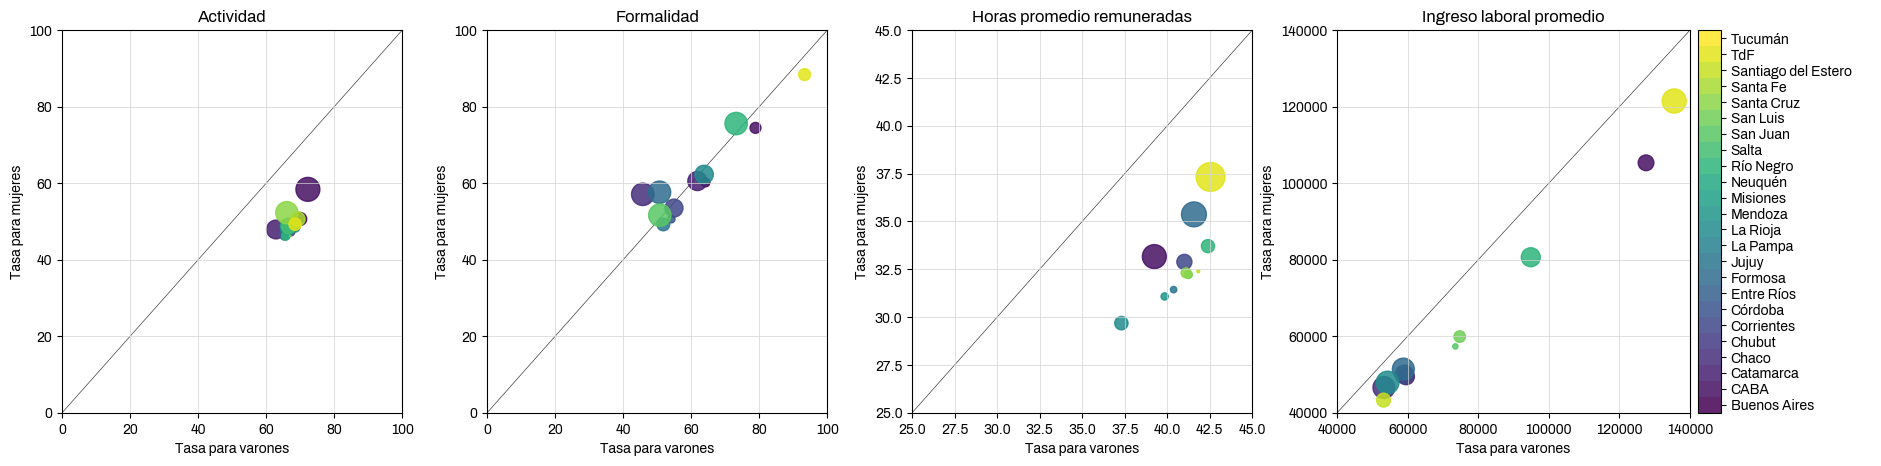

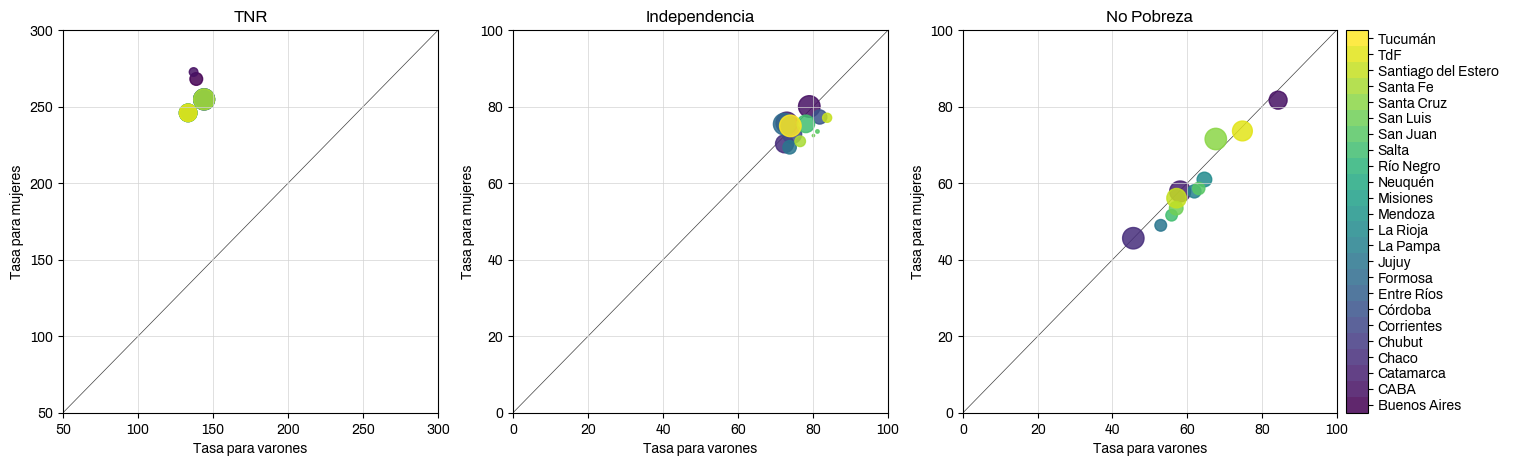

In [124]:
from matplotlib.colors import Normalize

grafico_labels = ['Actividad', 'Formalidad', 'Horas promedio remuneradas', 'Ingreso laboral promedio']
variables = [ratio_actividad, empleo_asalariado_con_descuento, horas_remuneradas_media, ingreso_salarial_media]
colors = fundar_colores_secundarios + fundar_colores_primarios
xlims = [[0,100], [0,100], [25,45], [40000, 140000]]
columnas = ['Actividad', 'Formalidad', 'Horas promedio remuneradas', 'Ingreso laboral promedio']

def generar_colores():
    cmap = plt.cm.get_cmap('viridis', 24)  # Cambiar 'viridis' por cualquier otra paleta de colores
    colores = cmap(np.arange(24))
    return colores

fig = plt.figure(figsize=(17,4.5))
pos = [[0.02, 0.05, 0.2, 0.85], [0.27, 0.05, 0.2, 0.85], [0.52, 0.05, 0.2, 0.85], [0.77, 0.05, 0.25, 0.85]]
for i, idf in enumerate(variables):
    normalized_values = (idf[columnas[i]] - idf[columnas[i]].mean()) / idf[columnas[i]].std()
    colores_por_provincia = generar_colores()
    etiquetas_numericas = np.arange(len(idf))

    ax = plt.axes(pos[i])
    scatter = ax.scatter(idf['Varon'], idf['Mujer'], s=normalized_values * 180, c=etiquetas_numericas, cmap='viridis', alpha=0.85)
    if i==3 or i==6:
        cbar = plt.colorbar(scatter, label=' ', orientation='vertical', pad=0.02, aspect=17, boundaries=np.arange(len(idf)+1)-0.5)
        cbar.set_ticks(np.arange(len(idf)))
        cbar.set_ticklabels(idf.index.tolist())
        #plt.clim(0, len(idf)-1)
    ax.set_xlabel('Tasa para varones')
    ax.set_ylabel('Tasa para mujeres')
    ax.set_title(grafico_labels[i])
    ax.set_xlim(xlims[i])
    ax.set_ylim(xlims[i])

    ax.grid(True, lw=0.5, color='lightgrey')
    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
        np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
        ]
    ax.plot(lims, lims, 'k-', alpha=0.75, lw=0.5, zorder=0)
plt.show()
fig.savefig(pathdata + 'figs/04_scatter_insercion' +'.png', dpi=400, bbox_inches='tight', transparent=True)
fig.savefig(pathdata + 'figs/04_scatter_insercion' +'.svg', bbox_inches='tight', transparent=True)
fig.savefig(pathdata + 'figs/04_scatter_insercion' +'.pdf', bbox_inches='tight', transparent=True)


grafico_labels = ['TNR', 'Independencia', 'No Pobreza']
variables = [ratio_minutos_promedio_no_pago, inactivos_con_ingreso, hogares_jefatura]
colors = fundar_colores_secundarios + fundar_colores_primarios
xlims = [[50,300], [0,100], [0,100]]
columnas = ['Tiempo TNR', 'Dependencia', 'No Pobreza']

fig = plt.figure(figsize=(15,4.5))
pos = [[0.05, 0.05, 0.25, 0.85], [0.35, 0.05, 0.25, 0.85], [0.65, 0.05, 0.3, 0.85]]
for i, idf in enumerate(variables):
    normalized_values = (idf[columnas[i]] - idf[columnas[i]].mean()) / idf[columnas[i]].std()
    colores_por_provincia = generar_colores()
    etiquetas_numericas = np.arange(len(idf))

    ax = plt.axes(pos[i])
    scatter = ax.scatter(idf['Varon'], idf['Mujer'], s=normalized_values * 180, c=etiquetas_numericas, cmap='viridis', alpha=0.85)
    if i==2:
        cbar = plt.colorbar(scatter, label=' ', orientation='vertical', pad=0.02, aspect=17, boundaries=np.arange(len(idf)+1)-0.5)
        cbar.set_ticks(np.arange(len(idf)))
        cbar.set_ticklabels(idf.index.tolist())
        #plt.clim(0, len(idf)-1)
    ax.set_xlabel('Tasa para varones')
    ax.set_ylabel('Tasa para mujeres')
    ax.set_title(grafico_labels[i])
    ax.set_xlim(xlims[i])
    ax.set_ylim(xlims[i])

    ax.grid(True, lw=0.5, color='lightgrey')
    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
        np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
        ]
    ax.plot(lims, lims, 'k-', alpha=0.75, lw=0.5, zorder=0)
plt.show()
fig.savefig(pathdata + 'figs/05_scatter_autonomia' +'.png', dpi=400, bbox_inches='tight', transparent=True)
fig.savefig(pathdata + 'figs/05_scatter_autonomia' +'.svg', bbox_inches='tight', transparent=True)
fig.savefig(pathdata + 'figs/05_scatter_autonomia' +'.pdf', bbox_inches='tight', transparent=True)
